In [1]:
import hashlib as hl
import numpy as np
import pandas as pd
import string
import re
import lightweight_mmm
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

import seaborn as sns


# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
import holidays
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from ydata_profiling import ProfileReport
import warnings
import nbimporter
import utils.utils_mmm as utils

from statsmodels.tsa.seasonal import STL 


from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Load and Transform Media Data

In [2]:
file_path = 'data/mmm_media.csv'
media_bi_df, media_mmm_df = utils.preprocess_media_data(file_path)

In [5]:
min_week = media_mmm_df.week_of.min()
max_week = media_mmm_df.week_of.max()

In [6]:
file_path = 'data/mmm_leads_policies.csv'

leads_bi_df, sales_bi_df, policies_mmm_df, premiums_mmm_df, leads_mmm_df = utils.preprocess_leads_policies_data(file_path, min_week, max_week)

In [ ]:
conv_rate_mmm_df 

In [29]:
conv_rate_mmm_df = leads_mmm_df.merge(policies_mmm_df, on='week_of')
conv_rate_mmm_df['conv_rate'] = conv_rate_mmm_df.policies / conv_rate_mmm_df.leads
conv_rate_mmm_df = conv_rate_mmm_df[['week_of', 'conv_rate']]

## Encode holidays

In [7]:
holidays_bi_df, holidays_mmm_df = utils.get_holidays(media_mmm_df)

In [8]:
# Import required libraries
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test
result = adfuller(premiums_mmm_df['premium_annual'])
print('ADF test:\tp-value: {:.5f}'.format(result[1]))

ADF test:	p-value: 0.00000


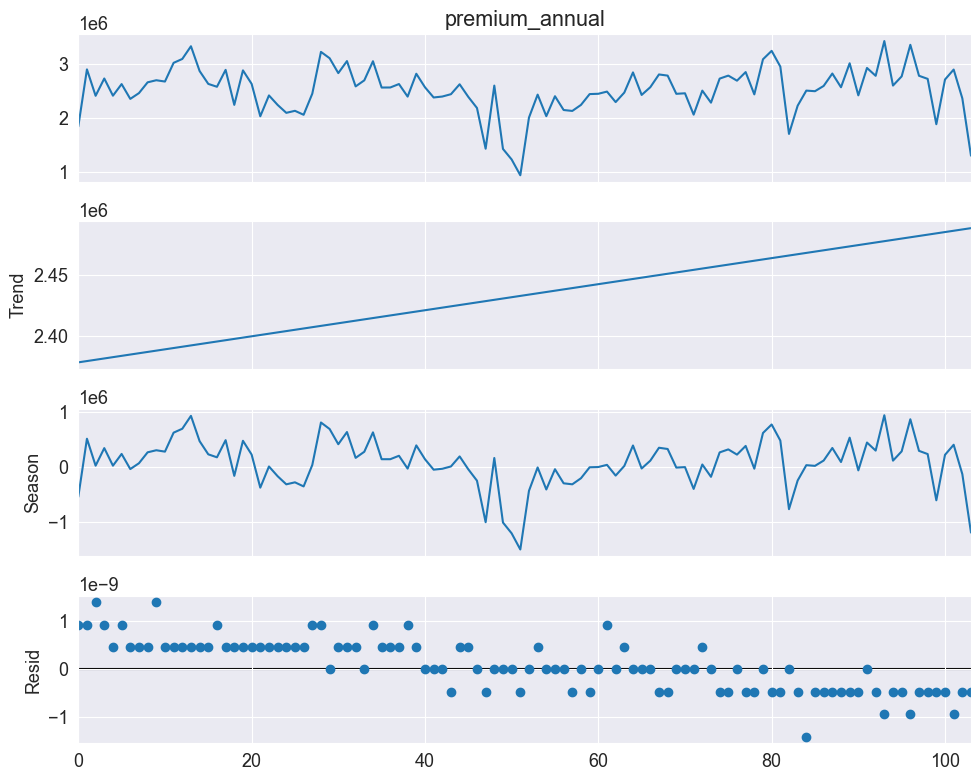

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL 

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=13)


# stl = STL(co2, seasonal=13)

premiums_sd = STL(premiums_mmm_df['premium_annual'], seasonal=13, period=52).fit()

fig = premiums_sd.plot()

plt.savefig('img/premium_annual_decompose.png')


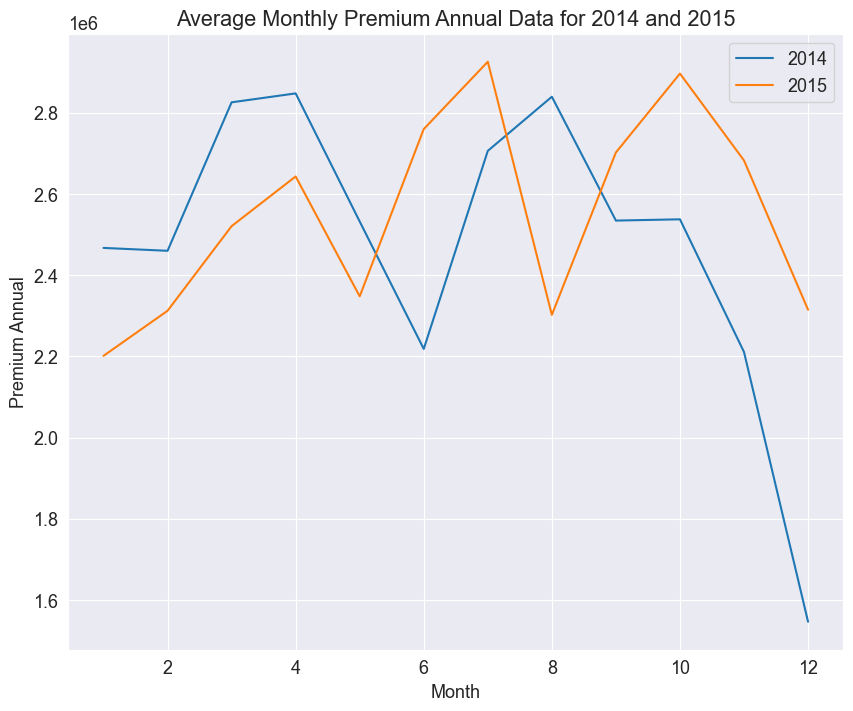

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
# Filter the data for 2014 and 2015
data_2014 = premiums_mmm_df[premiums_mmm_df['week_of'].dt.year == 2014]
data_2015 = premiums_mmm_df[premiums_mmm_df['week_of'].dt.year == 2015]

# Extract month from week_of column
data_2014['month'] = data_2014['week_of'].dt.month
data_2015['month'] = data_2015['week_of'].dt.month

# Group by month and calculate the mean premium_annual for each month
data_2014_monthly = data_2014.groupby('month')['premium_annual'].mean()
data_2015_monthly = data_2015.groupby('month')['premium_annual'].mean()

# Plot the data
plt.plot(data_2014_monthly.index, data_2014_monthly.values, label='2014')
plt.plot(data_2015_monthly.index, data_2015_monthly.values, label='2015')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Premium Annual')
plt.title('Average Monthly Premium Annual Data for 2014 and 2015')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [11]:
import statsmodels.api as sm

sm.stats.acorr_ljungbox(premiums_sd.resid, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,189.920168,4.063281e-39


In [12]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test:
print('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(premiums_mmm_df['premium_annual'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -5.817508e+00
p-value                        4.258345e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


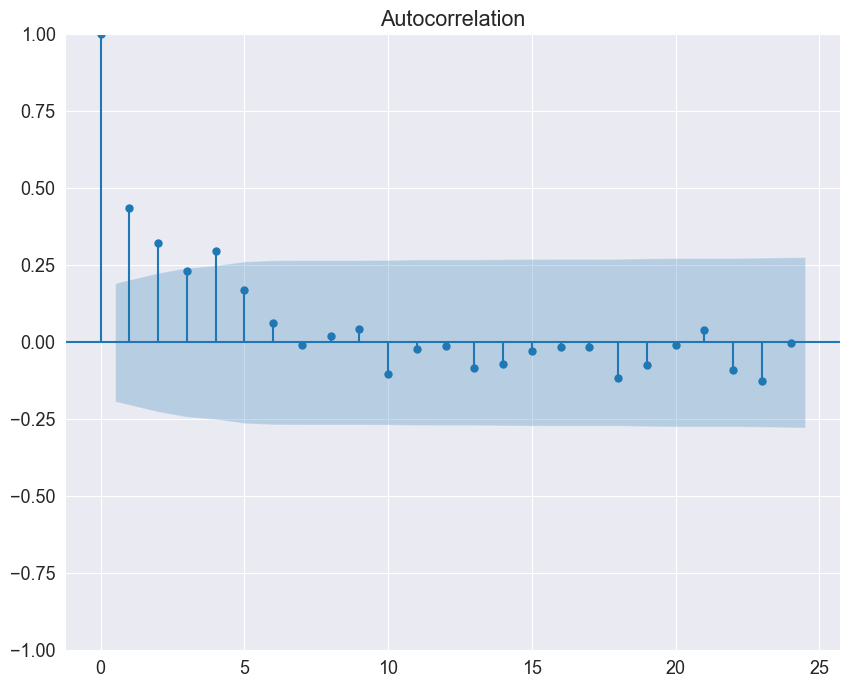

In [13]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(premiums_mmm_df['premium_annual'], lags=24)
pyplot.savefig('acf_plot.png')
pyplot.show()

In [20]:
premiums_mmm_df = premiums_mmm_df.reset_index()[['week_of', 'premium_annual']]
premiums_mmm_df['premium_annual-1'] = premiums_mmm_df['premium_annual'].shift(1)
premiums_mmm_df['premium_annual-2'] = premiums_mmm_df['premium_annual'].shift(2)

# MMM Model

In [30]:
mmm_premiums_df = premiums_mmm_df.merge(holidays_mmm_df, on='week_of', how='left').merge(conv_rate_mmm_df, on='week_of').merge(media_mmm_df, on='week_of')
# mmm_premiums_df = premiums_mmm_df.merge(conv_rate_mmm_df, on='week_of').merge(media_mmm_df, on='week_of')
mmm_premiums_df['seasonal'] = pd.Series(premiums_sd.seasonal.values)
mmm_premiums_df['trend'] = pd.Series(premiums_sd.trend.values)
mmm_premiums_df.fillna(0, inplace=True)

In [31]:
SEED = 105
data_size = len(mmm_premiums_df)
holiday_cols = [col for col in mmm_premiums_df.columns if 'holiday' in col]
seasonality_cols = [col for col in mmm_premiums_df.columns if 'seasonal' in col]
media_spend_cols = [col for col in mmm_premiums_df.columns if 'spend' in col]
other_feature_cols = ['conv_rate'] + ['trend'] + ['premium_annual-1'] + ['premium_annual-2']
extra_feature_cols = seasonality_cols + other_feature_cols

# holiday_cols + 

In [32]:
mmm_premiums_df[holiday_cols] = mmm_premiums_df[holiday_cols].astype(int)
mmm_premiums_df.sort_values(by='week_of', inplace=True)

In [33]:
data_size = len(mmm_premiums_df)
n_media_channels = len(media_spend_cols)
n_extra_features = len(extra_feature_cols)
media_data = mmm_premiums_df[media_spend_cols].to_numpy()
extra_features = mmm_premiums_df[extra_feature_cols].to_numpy()
target = mmm_premiums_df['premium_annual'].to_numpy()
costs = mmm_premiums_df[media_spend_cols].sum().to_numpy()

In [34]:
# Split and scale data.
test_data_period_size = 20
split_point = data_size - test_data_period_size

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

In [35]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [36]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

In [37]:
number_warmup=1000
number_samples=1000

In [38]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names = media_spend_cols,
    seed=SEED)

sample: 100%|██████████| 2000/2000 [00:22<00:00, 90.50it/s, 104 steps of size 6.53e-03. acc. prob=0.87]  


In [39]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.02      0.00      0.02      0.02      0.02   1688.63      1.00
             coef_extra_features[1]      0.21      0.07      0.21      0.09      0.33    808.74      1.00
             coef_extra_features[2]     -0.10      0.50     -0.04     -0.89      0.68    535.20      1.00
             coef_extra_features[3]     -0.05      0.05     -0.05     -0.13      0.03   1045.14      1.00
             coef_extra_features[4]      0.00      0.04      0.00     -0.06      0.08   1017.14      1.00
                      coef_media[0]      0.02      0.02      0.02      0.00      0.04   1471.28      1.00
                      coef_media[1]      0.01      0.01      0.01      0.00      0.02   1658.23      1.00
                      coef_media[2]      0.02      0.02      0.02      0.00      0.05   1509.10      1.00
                      coef_media[3]      0.27

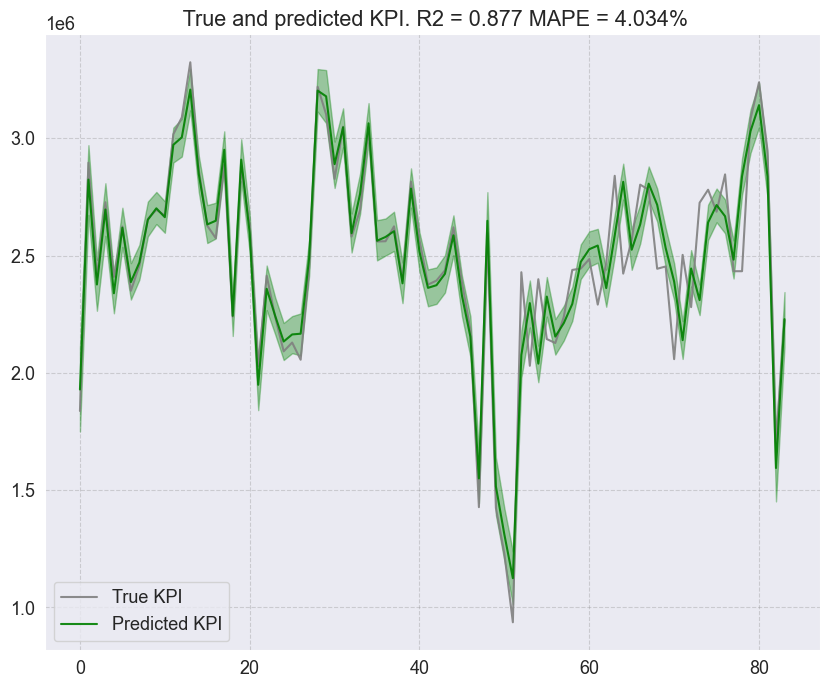

In [40]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

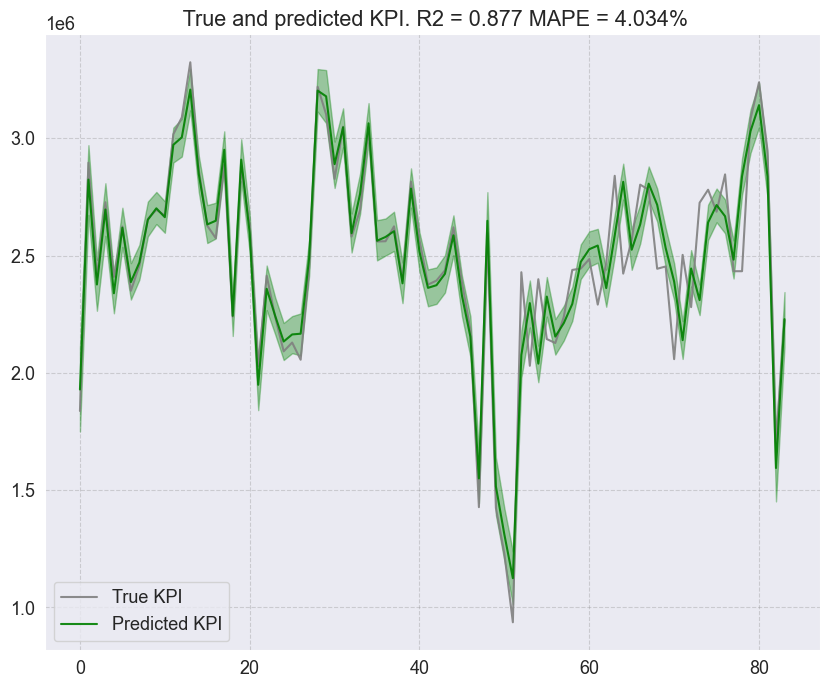

In [41]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

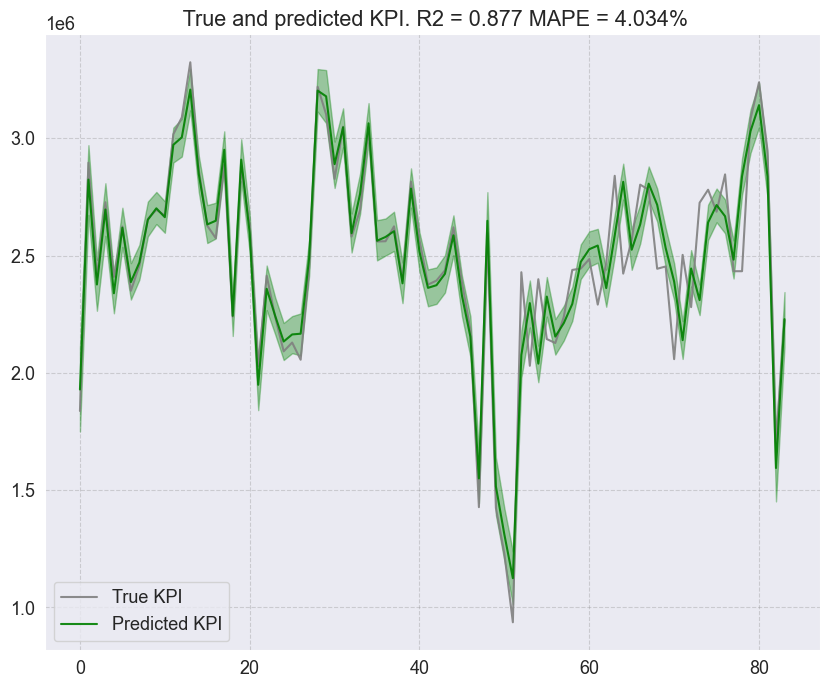

In [42]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [43]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)

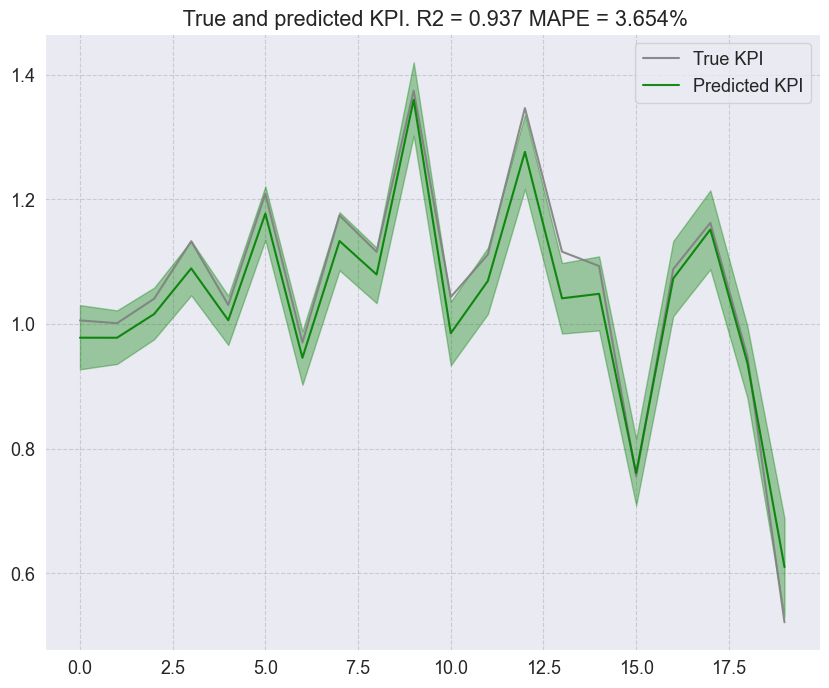

In [44]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

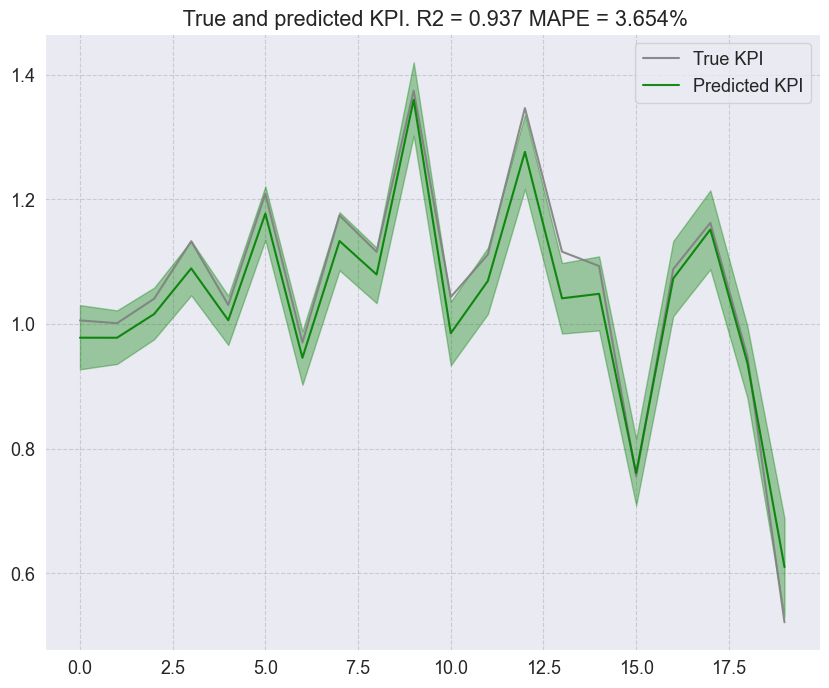

In [45]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

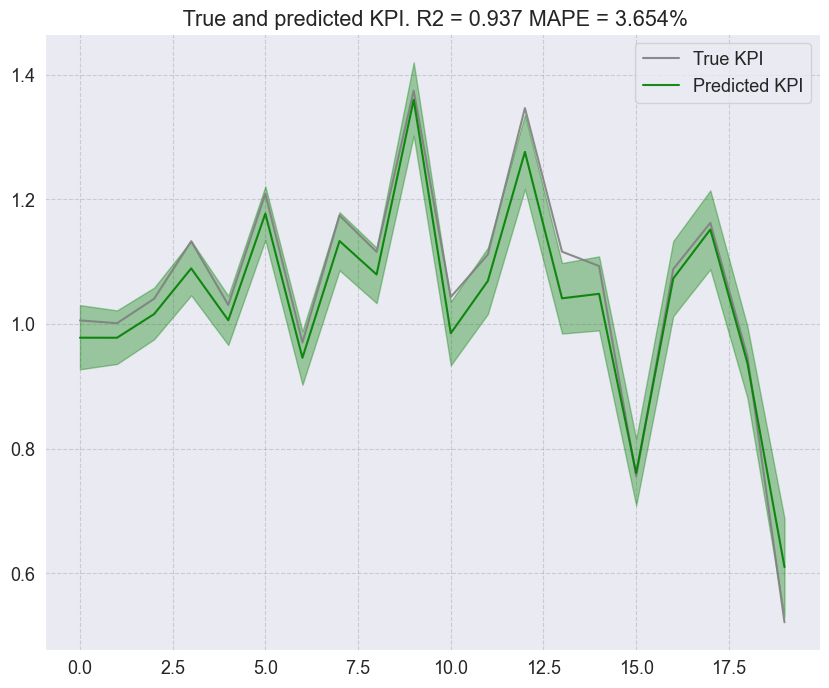

In [46]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

In [423]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

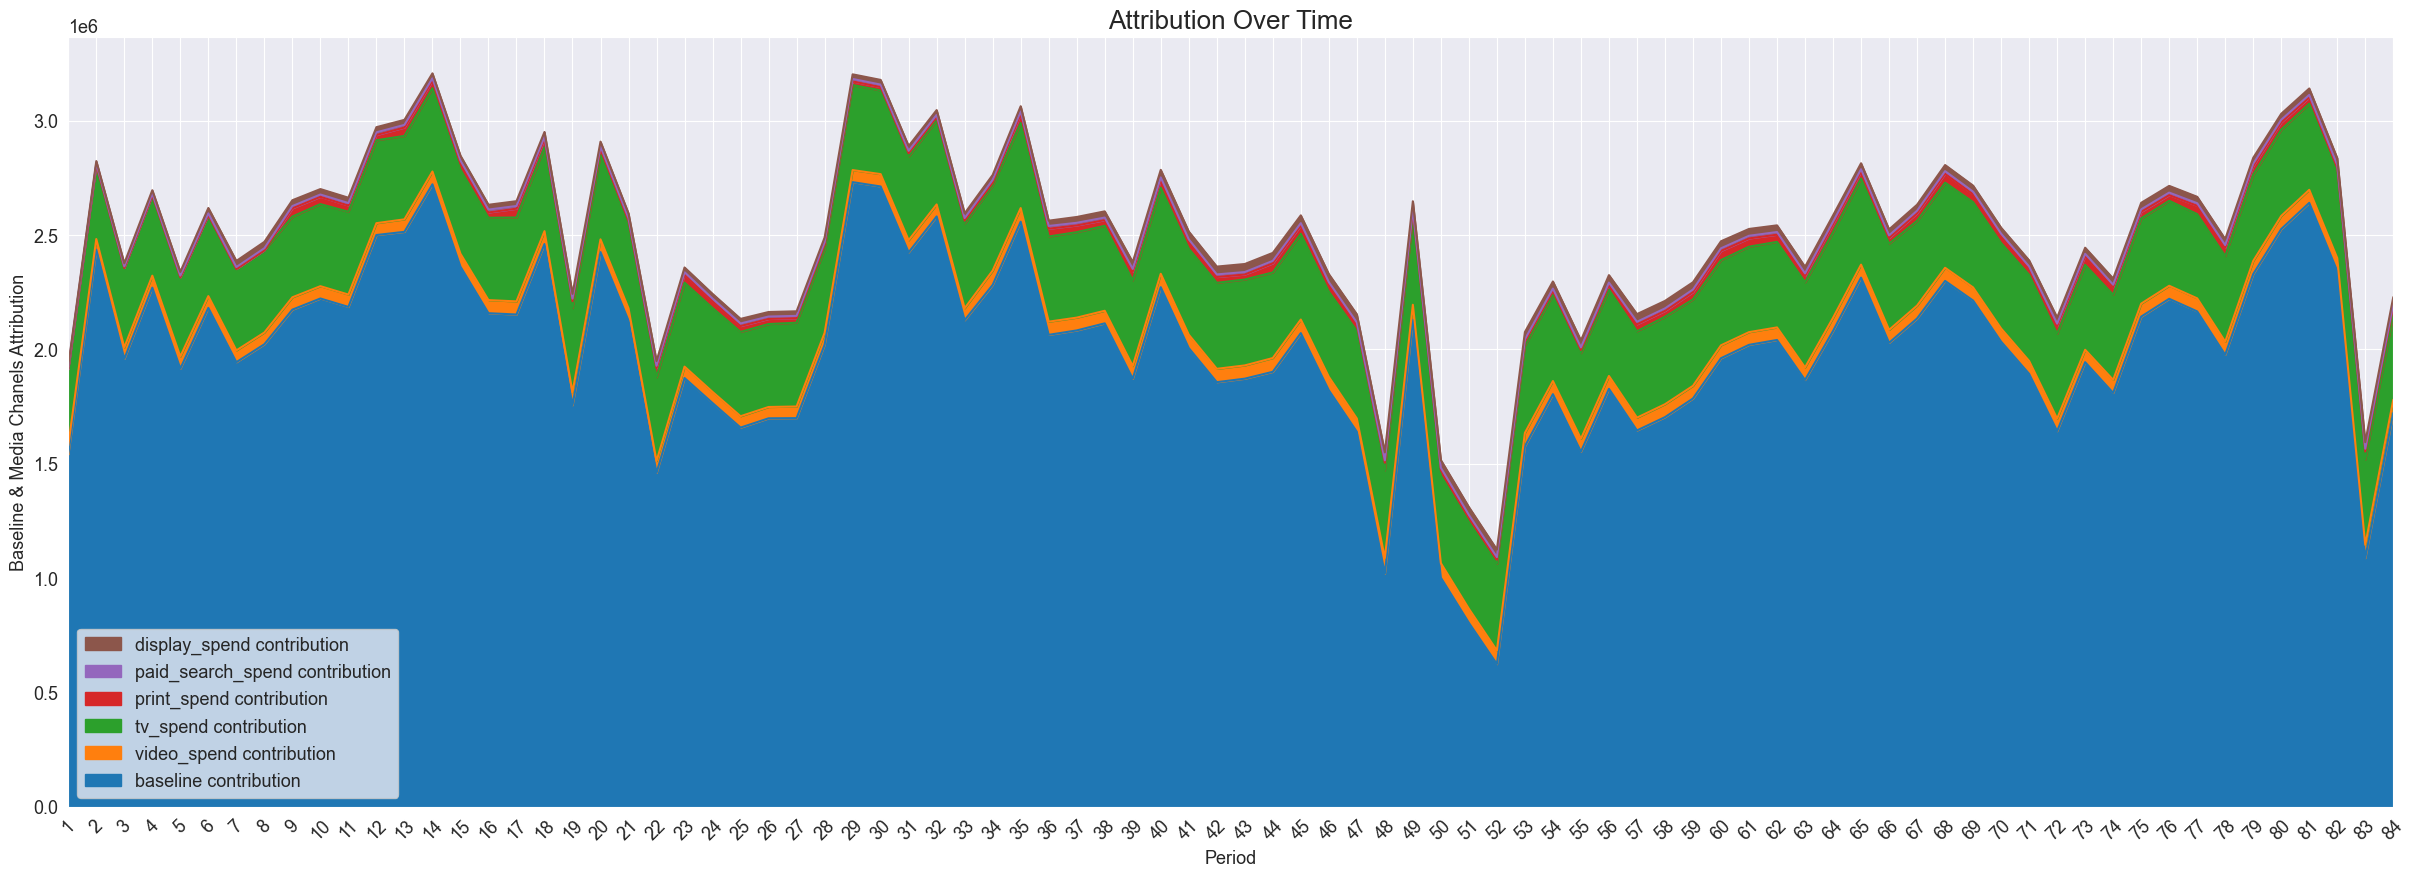

In [359]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = media_spend_cols
                                                )
                                                

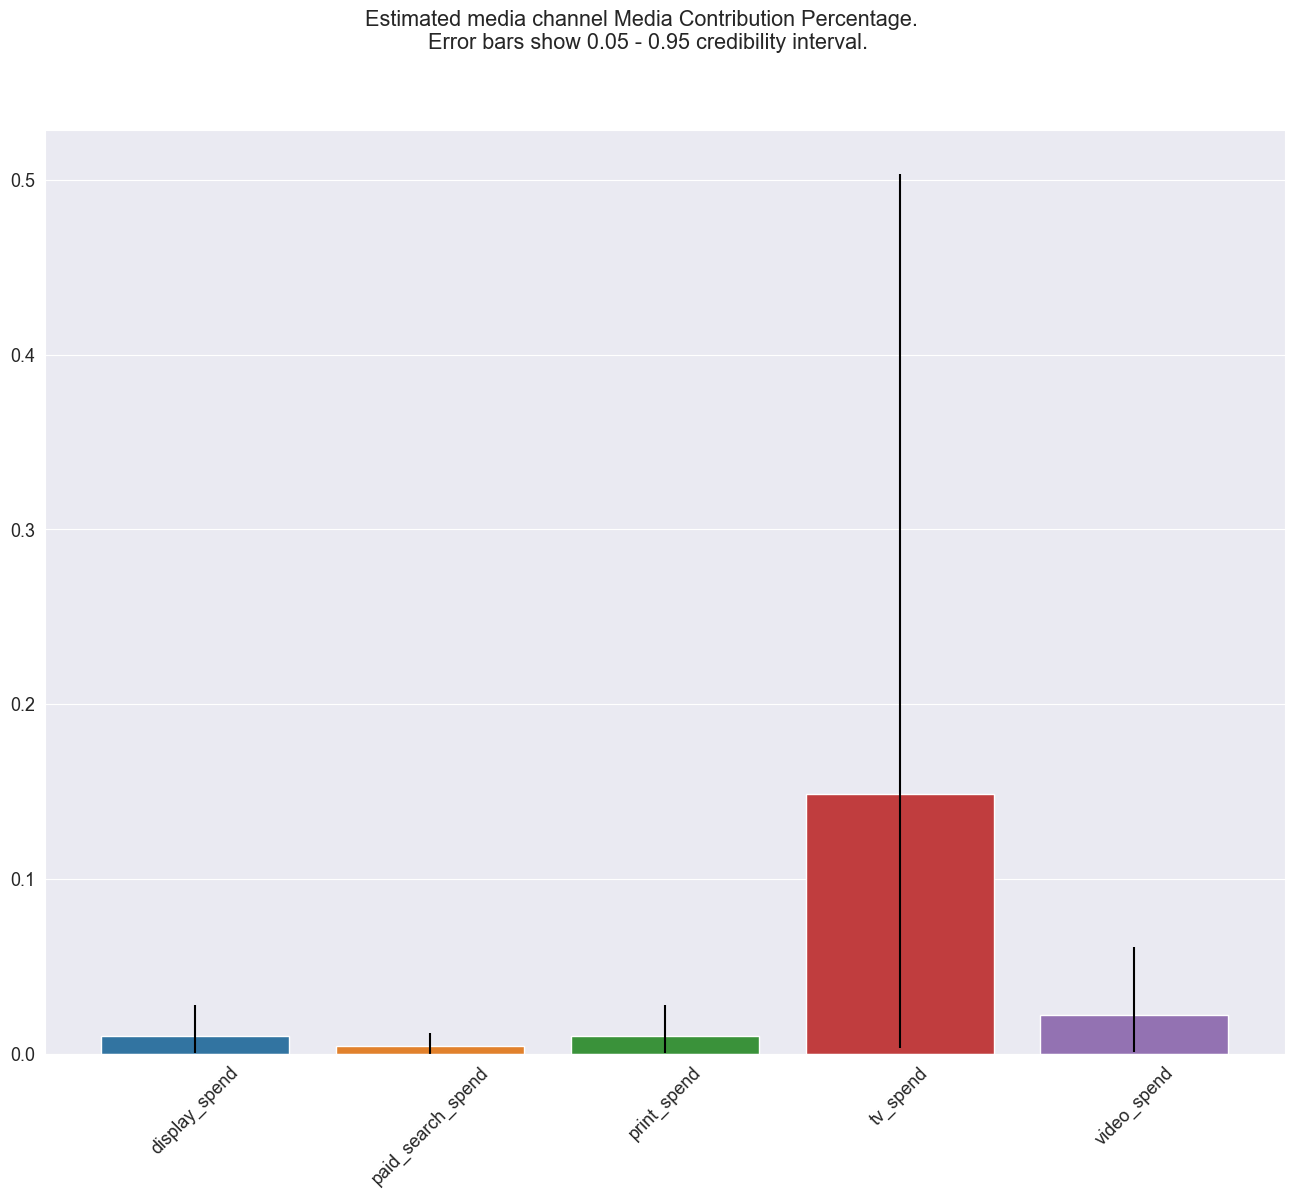

In [360]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=media_spend_cols)

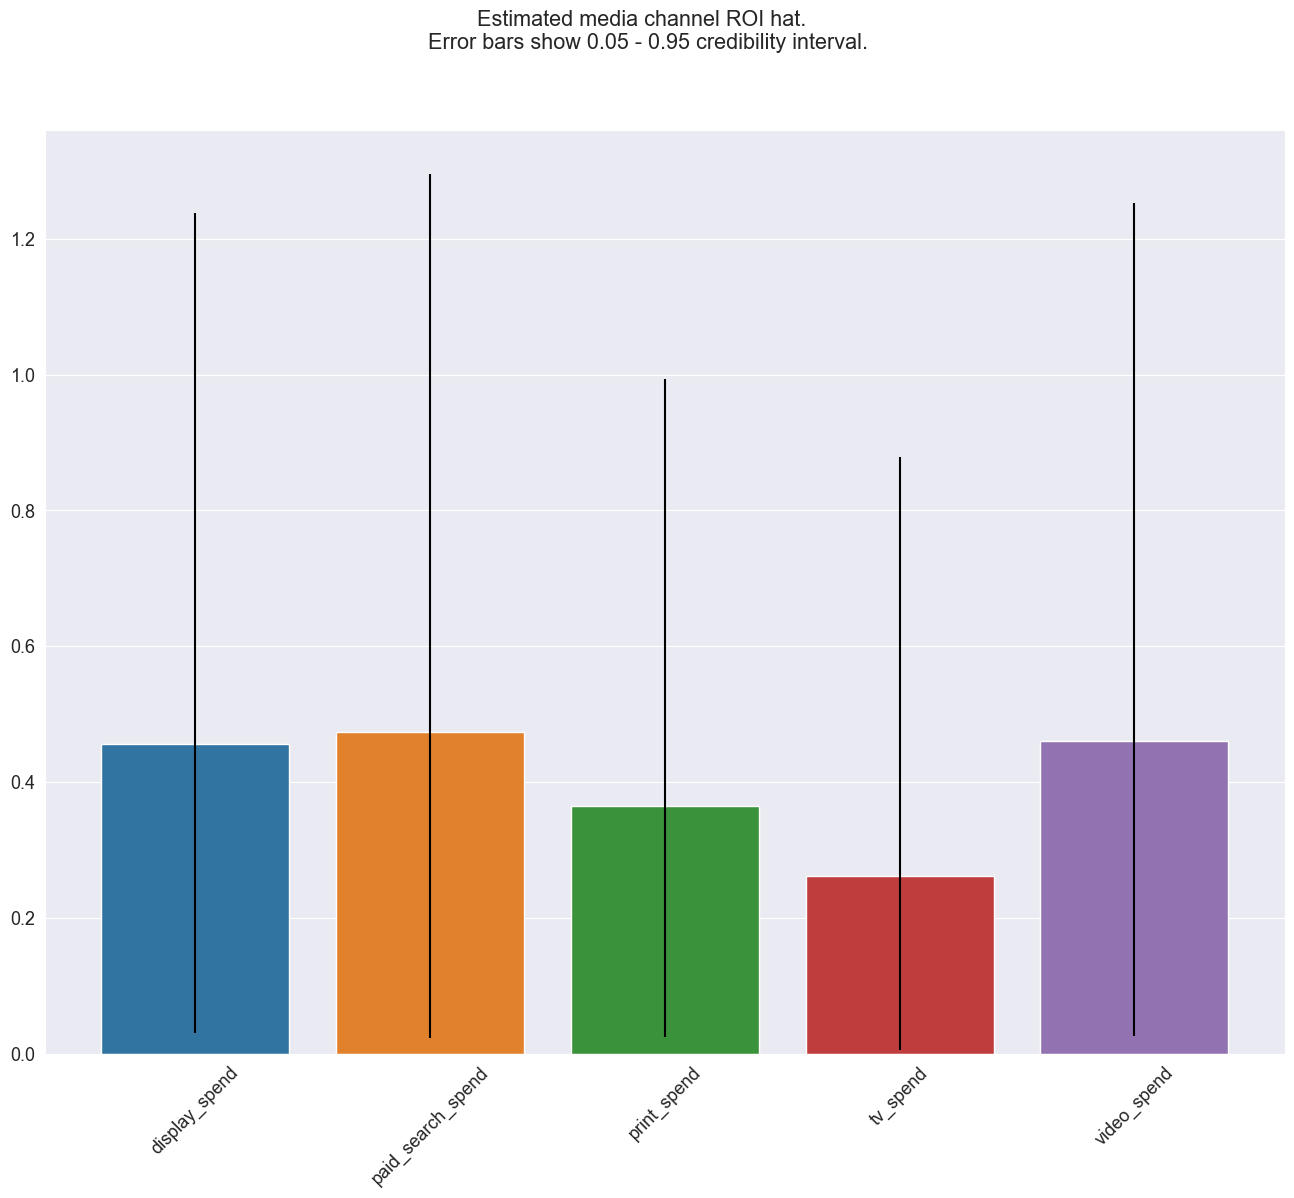

In [361]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=media_spend_cols)

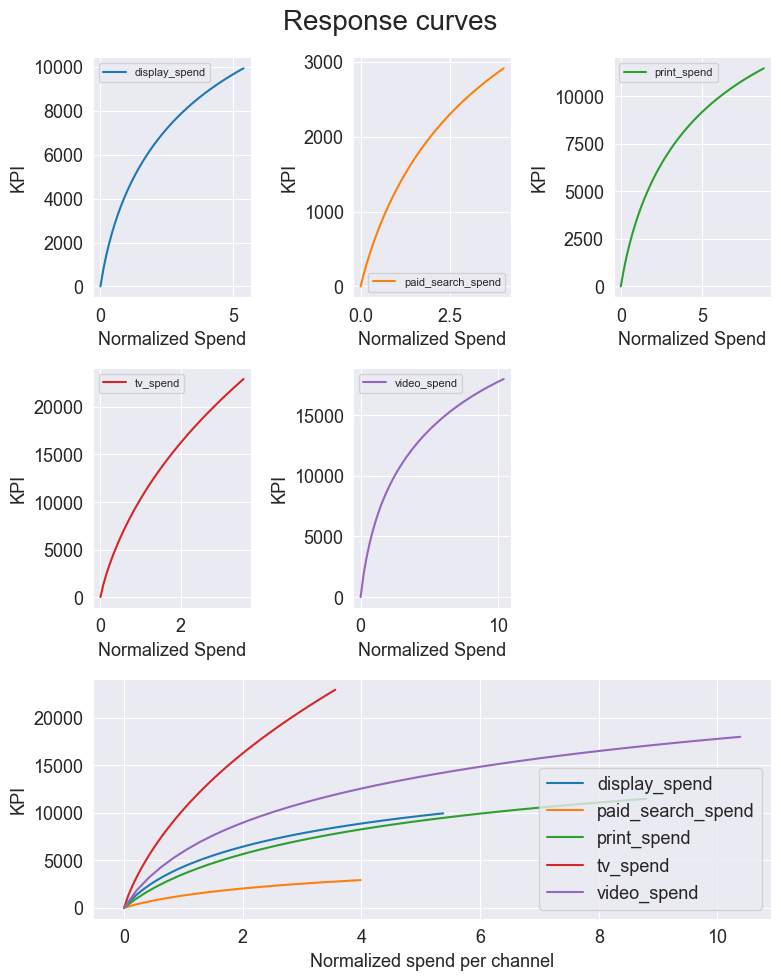

In [362]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

In [363]:
prices = jnp.ones(mmm.n_media_channels)
n_time_periods = 20
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    bounds_upper_pct=1.5, 
    seed=SEED)

# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

print(kpi_without_optim)
print(optimal_buget_allocation)
print(previous_budget_allocation)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -51836528.04944943
            Iterations: 57
            Function evaluations: 616
            Gradient evaluations: 56
-51556932.0
[ 1812797.6   820007.3  2661439.5 18630370.   3321077.5]
[  721249.44   368292.66  1181308.2  23163684.    1811156.9 ]


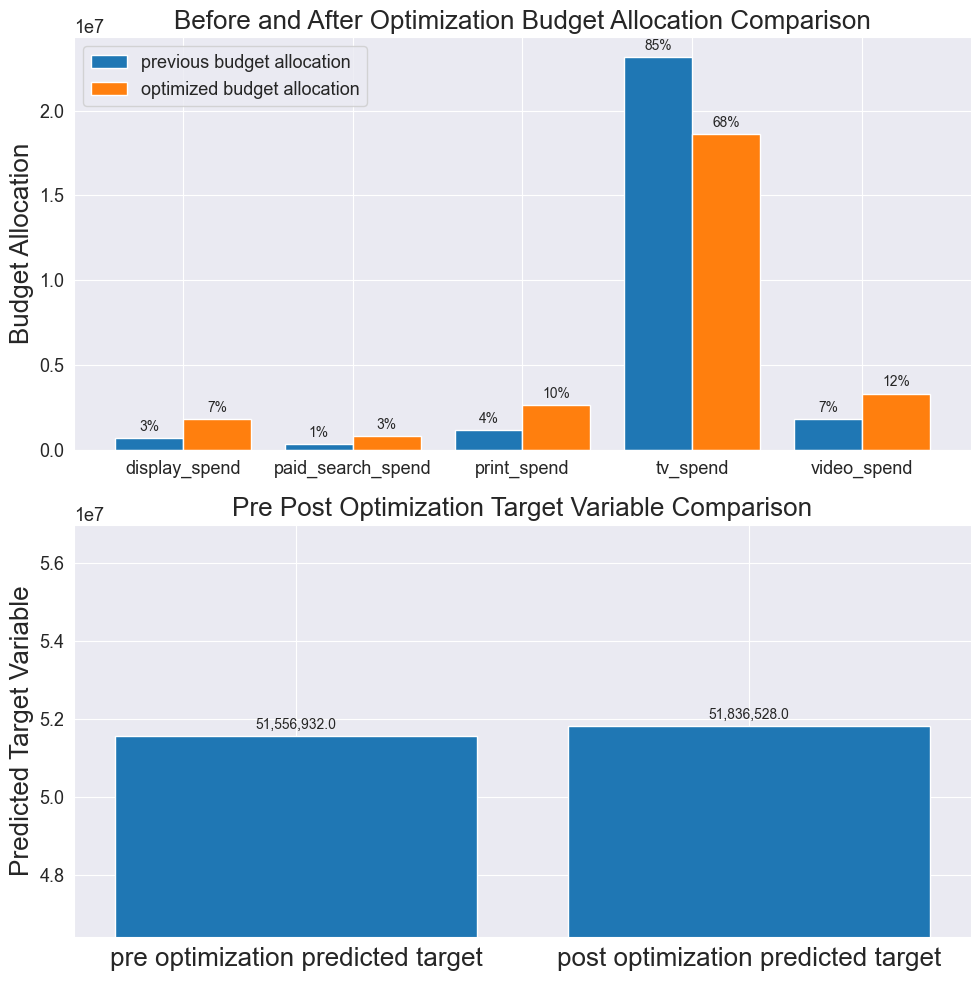

In [364]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10),
                                                channel_names = media_spend_cols)